## Multiscale HiTS

### created by Yuying Liu, 05/07/2020

This script is a template for benchmarking multiscale HiTS against single time-scale neural network time-steppers. We find multiscale HiTS can provide the most accurate forecasts with good efficiency. 

With the help of this script, one can reproduce:
- Figure 5
- Table 5

In [1]:
import os
import sys
import time
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [2]:
# adjustables
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'Hyperbolic'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'

In [3]:
# path
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
ks = list(range(11))
step_sizes = [2**k for k in ks]

### load data & models

In [4]:
# load validation set and test set
val_data = np.load(os.path.join(data_dir, 'val_noise0.0.npy'))
test_data = np.load(os.path.join(data_dir, 'test_noise0.0.npy'))

In [5]:
# load models
models = list()
n_forward_list = [1, 2, 3, 4, 5, 10, 15, 20]
step_size = 4
for n_forward in n_forward_list:
#     print('load model_D{}.pt'.format(step_size))
#     try:
        noise = 0.0
        model_name = 'model_D{}_noise{}_n_forward{}.pt'.format(step_size, noise, n_forward)
        print('load ', model_name)
        models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
#     except:
        
#         break

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load  model_D4_noise0.0_n_forward1.pt
load  model_D4_noise0.0_n_forward2.pt
load  model_D4_noise0.0_n_forward3.pt
load  model_D4_noise0.0_n_forward4.pt
load  model_D4_noise0.0_n_forward5.pt
load  model_D4_noise0.0_n_forward10.pt
load  model_D4_noise0.0_n_forward15.pt
load  model_D4_noise0.0_n_forward20.pt


/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kjohnst/.local/lib/python3.6/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [7]:
# model_D8_noise0.0_n_forward1.pt

### benchmarks

In [8]:
# shared info
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

In [9]:
 def uni_scale_forecast(self, x_init, n_steps):
        """
        :param x_init: array of shape n_test x input_dim
        :param n_steps: number of steps forward in terms of dt
        :return: predictions of shape n_test x n_steps x input_dim and the steps
        """
        steps = list()
        preds = list()
        sample_steps = range(n_steps)

        # forward predictions
        x_prev = x_init
        cur_step = self.step_size - 1
        while cur_step < n_steps + self.step_size:
            x_next = self.forward(x_prev)
            steps.append(cur_step)
            preds.append(x_next)
            cur_step += self.step_size
            x_prev = x_next

        # include the initial frame
        steps.insert(0, 0)
        print(x_init[0])
        preds.insert(0, torch.tensor(x_init).float().to(self.device))
        
        print(preds[0][0])

        # interpolations
        preds = torch.stack(preds, 2).detach().numpy()
        cs = scipy.interpolate.interp1d(steps, preds, kind='linear')
        y_preds = torch.tensor(cs(sample_steps)).transpose(1, 2).float()
        print(y_preds[0,0])

        return y_preds

In [10]:
y_preds = uni_scale_forecast(models[0], torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)

tensor([0.9655, 0.1720])
tensor([0.9655, 0.1720])
tensor([0.9655, 0.1720])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


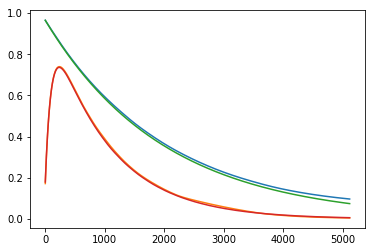

In [11]:
plt.plot(y_preds[0,:,0])
plt.plot(y_preds[0,:,1])
# plt.show()

plt.plot(test_data[0,1:,0])
plt.plot(test_data[0,1:,1])

In [12]:
print(y_preds[0,0])
print(torch.tensor(test_data[0, 0, :]))

tensor([0.9655, 0.1720])
tensor([0.9655, 0.1720], dtype=torch.float64)


In [13]:
print(y_preds[0,0])

tensor([0.9655, 0.1720])


  0%|          | 0/8 [00:00<?, ?it/s]

/home/kjohnst/multiscale_HiTS_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


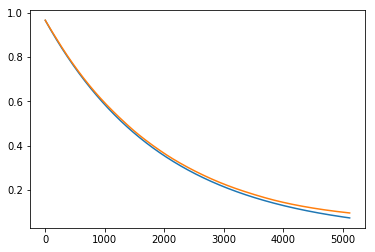

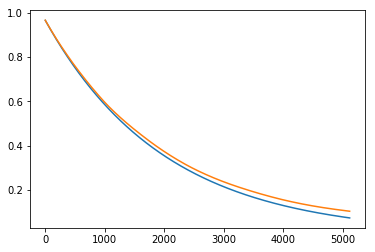

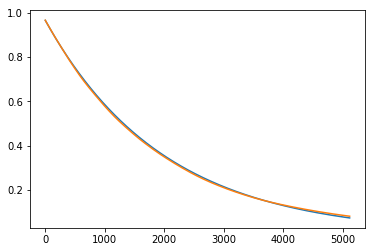

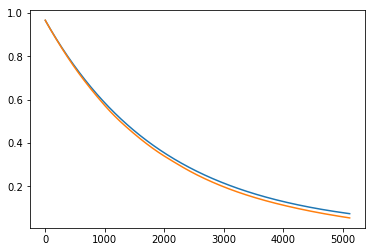

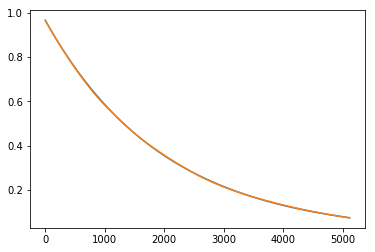

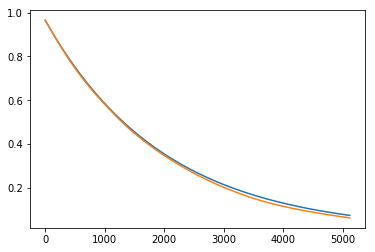

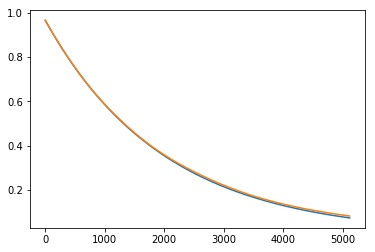

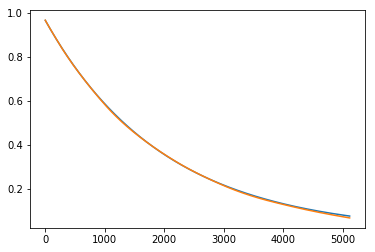

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02]), <a list of 9 Text yticklabel objects>)

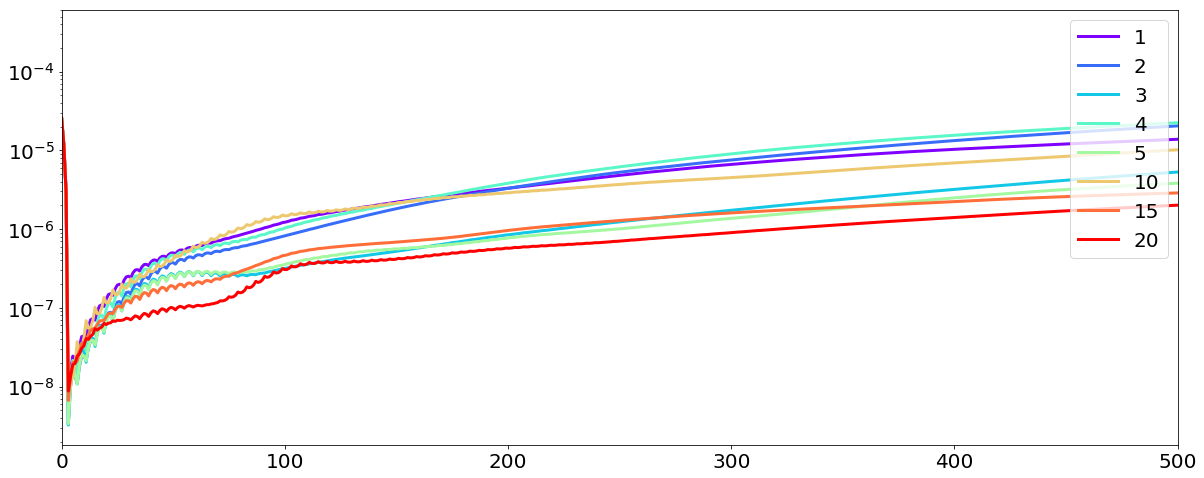

In [14]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
    
    plt.plot(test_data[0, 1:, 0])
    plt.plot(y_preds[0,:,0])
    plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label=n_forward_list[k])
plt.xlim([0,500])
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02]), <a list of 9 Text yticklabel objects>)

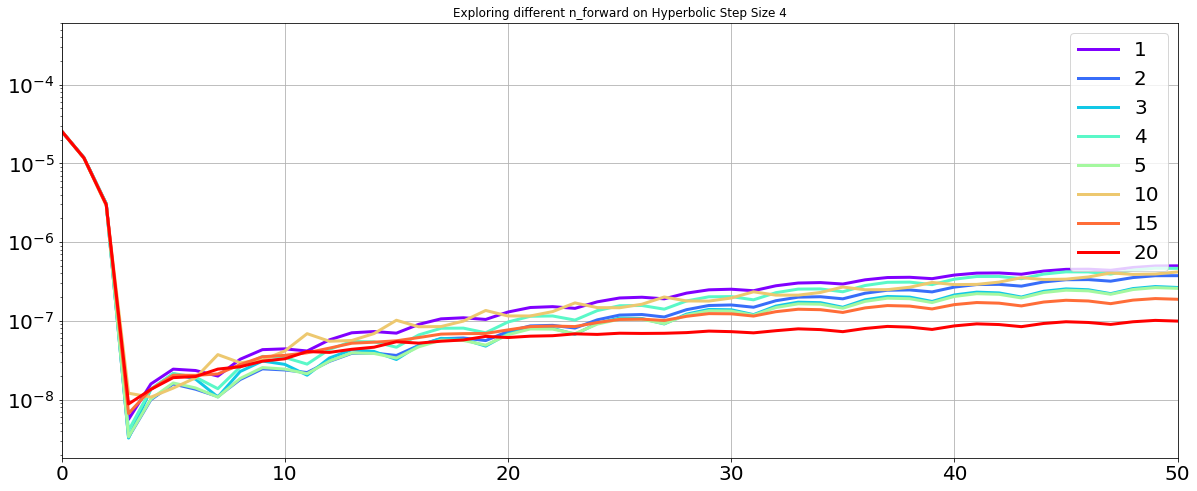

In [19]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label=n_forward_list[k])
plt.xlim([0,50])
plt.grid()
plt.title("Exploring different n_forward on Hyperbolic Step Size 4")
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
# cross validation (model selections) 
start_idx = 0
end_idx = len(models)
best_mse = 1e+5
# choose the largest time step
for i in tqdm(range(len(models))):
#     print("val_data devioce = ", val_data.device)?
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float().to('cpu'), n_steps=n_steps, models=models[:len(models)-i])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        end_idx = len(models)-i
        best_mse = mse

        # choose the smallest time step
for i in tqdm(range(end_idx)):
    y_preds = net.vectorized_multi_scale_forecast(torch.tensor(val_data[:, 0, :]).float().to('cpu'), n_steps=n_steps, models=models[i:end_idx])
    mse = criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean().item()
    if mse <= best_mse:
        start_idx = i
        best_mse = mse
        
print('use models {} - {}.'.format(start_idx, end_idx))
models = models[start_idx:end_idx]

In [ ]:
# multiscale time-stepping with NN
start = time.time()
y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)
end = time.time()
multiscale_time = end - start
multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)

# visualize forecasting error at each time step    
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
multiscale_err = multiscale_preds_mse.mean(0).detach().numpy()
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(t, mean, linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.semilogy(t, multiscale_err, linestyle='-', color='k', linewidth=6, label='multiscale')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)

In [ ]:
# integration of a sampled test trial 
# (you need to change the code here accordingly as state variables are different for different systems)
idx = 15
t = np.linspace(0, (n_steps-1)*dt, n_steps)
fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(t, test_data[idx, 0:n_steps, 0], 'r-', linewidth=10, label='x')
ax0.plot(t, test_data[idx, 0:n_steps, 1], 'b-', linewidth=10, label='y')
# ax0.plot(t, test_data[idx, 0:n_steps, 2], 'g-', linewidth=10, label='z')
ax0.plot(t, y_preds[idx, 0:n_steps, 0].detach().numpy(), 'k--', linewidth=10, label='learned')
ax0.plot(t, y_preds[idx, 0:n_steps, 1].detach().numpy(), 'k--', linewidth=10)
# ax0.plot(t, y_preds[idx, 0:n_steps, 2].detach().numpy(), 'k--', linewidth=10)
ax0.legend(fontsize=50, loc='upper right')
ax0.tick_params(axis='both', which='major', labelsize=60)

In [ ]:
# computation time
for i in range(len(times)):
    print('single scaled model (Dt={}): computing time {}s'.format(step_sizes[i]*dt, times[i]))
print('ensembled multiscale model: computing time {}s'.format(multiscale_time))